In [1]:
import os
import fnmatch
import itertools
from datetime import datetime
from pathlib import Path

import geowombat as gw
from geowombat.models import CRFClassifier

import satsmooth as sm

from mpglue.classification._moving_window import moving_window

import geopandas as gpd
import numpy as np
import cv2
import rasterio as rio
from rasterio.coords import BoundingBox
import numba as nb
from skimage.exposure import rescale_intensity
import sklearn_crfsuite
from sklearn.preprocessing import LabelEncoder
from affine import Affine
from tqdm import tqdm, trange
import pymorph

import matplotlib.pyplot as plt

## Functions

In [2]:
@nb.jit
def sample_to_dict(tsp, *args):
    
    """
    Args:
        tsp (1d)
    """

    nt = len(tsp)
    
    if args:

        n_args = len(args)

        tlab = np.empty(nt+n_args, dtype=object)
        tval = np.zeros(nt+n_args, dtype='float64')

    else:

        tlab = np.empty(nt, dtype=object)
        tval = np.zeros(nt, dtype='float64')    
    
    for r in range(0, nt):
        
        tlab[r] = str(r+1).encode('utf-8')    
        tval[r] = tsp[r]
    
    if args:

        for i, (arg_name, arg_value) in enumerate(args):

            tlab[r+i+1] = arg_name.encode('utf-8')
            tval[r+i+1] = arg_value    
    
    return dict(zip(tlab.tolist(), tval))


def _nan_check(value):
    return 0.0 if np.isnan(value) else value


def _min(a, b):
    return a if a < b else b


def _max(a, b):
    return a if a > b else b


def _clip_low(value):
    return 0.0 if value < 0 else value


def _clip_high(value):
    return 1.0 if value > 1 else value


def _clip(value):
    return _clip_low(value) if value < 1 else _clip_high(value)


def _evi(blue, red, nir):
    """Enhanced Vegetation Index"""
    return 2.5 * ((nir - red) / (nir + 6.0 * red - 7.5 * blue + 1.0))


def _evi2(red, nir):
    """Two-band Enhanced Vegetation Index"""
    return 2.5 * ((nir - red) / (nir + 1.0 + (2.4 * red)))


def _bsi(blue, red, nir, swir2):
    """Bare Soil Index"""
    return ((swir2 + red) - (nir - blue)) / ((swir2 + red) + (nir - blue))


def _brightness(green, red, nir):
    """Brightness Index"""
    return (green**2 + red**2 + nir**2)**0.5


def _brightness_swir(green, red, nir, swir1):
    """Brightness Index"""
    return (green**2 + red**2 + nir**2 + swir1**2)**0.5


def _dbsi(green, red, nir, swir1):
    """Dry Bare Soil Index"""
    return ((swir1 - green) / (swir1 + green)) - _ndvi(red, nir)


def _nbr(nir, swir2):
    """Normalized Burn Ratio"""
    return (nir - swir2) / (nir + swir2)


def _ndmi(nir, swir1):
    """Normalized Difference Moisture Index"""
    return (nir - swir1) / (nir + swir1)


def _ndvi(red, nir):
    """Normalized Difference Vegetation Index"""
    return (nir - red) / (nir + red)


def _wi(red, swir1):
    """Woody Index"""
    return 0.0 if red + swir1 > 0.5 else 1.0 - ((red + swir1) / 0.5)

    
SENSOR_BANDS = dict(l7=dict(blue=0,
                            green=1,
                            red=2,
                            nir=3,
                            swir1=4,
                            swir2=5),
                    l8=dict(blue=0,
                            green=1,
                            red=2,
                            nir=3,
                            swir1=4,
                            swir2=5),
                    l5bgrn=dict(blue=0,
                                green=1,
                                red=2,
                                nir=3),
                    l7bgrn=dict(blue=0,
                                green=1,
                                red=2,
                                nir=3),
                    l8bgrn=dict(blue=0,
                                green=1,
                                red=2,
                                nir=3),
                    bgrn=dict(blue=0,
                              green=1,
                              red=2,
                              nir=3),
                    qb=dict(blue=0,
                            green=1,
                            red=2,
                            nir=3),
                    ps=dict(blue=0,
                            green=1,
                            red=2,
                            nir=3),
                    s210=dict(blue=0,
                              green=1,
                              red=2,
                              nir=3),
                    s220=dict(nir1=0,
                              nir2=1,
                              nir3=2,
                              rededge=3,
                              swir1=4,
                              swir2=5),
                    s2l7=dict(blue=0,
                              green=1,
                              red=2,
                              nir=3,
                              swir1=4,
                              swir2=5))    

# @nb.jit
def array_to_dict(sensor, *args):
    
    """
    Converts an array sample to a CRF features
    """
    
    nargs = len(args)
    feas = list()
    
    if sensor != 'pan':
        
        if sensor in ['s210', 'l5bgrn', 'l7bgrn', 'l8bgrn', 'bgrn', 'qb', 'ps']:

            blue_idx = SENSOR_BANDS[sensor]['blue']
            green_idx = SENSOR_BANDS[sensor]['green']
            red_idx = SENSOR_BANDS[sensor]['red']
            nir_idx = SENSOR_BANDS[sensor]['nir']
            
        elif sensor == 's220':

            nir1_idx = SENSOR_BANDS[sensor]['nir1']
            nir2_idx = SENSOR_BANDS[sensor]['nir2']
            nir3_idx = SENSOR_BANDS[sensor]['nir3']
            rededge_idx = SENSOR_BANDS[sensor]['rededge']
            swir1_idx = SENSOR_BANDS[sensor]['swir1']
            swir2_idx = SENSOR_BANDS[sensor]['swir2']
            
        else:

            blue_idx = SENSOR_BANDS[sensor]['blue']
            green_idx = SENSOR_BANDS[sensor]['green']
            red_idx = SENSOR_BANDS[sensor]['red']
            nir_idx = SENSOR_BANDS[sensor]['nir']
            swir1_idx = SENSOR_BANDS[sensor]['swir1']
            swir2_idx = SENSOR_BANDS[sensor]['swir2']

    for si in range(0, nargs):
        
        tsamp = args[si]*0.0001

        if sensor == 'pan':            
            feas.append(sample_to_dict(tsamp))            
        else:
            
            if sensor in ['s210', 'l5bgrn', 'l7bgrn', 'l8bgrn', 'bgrn', 'qb', 'ps']:
            
                brightness = _brightness(tsamp[green_idx], tsamp[red_idx], tsamp[nir_idx])
                evi = _evi(tsamp[blue_idx], tsamp[red_idx], tsamp[nir_idx])                
                evi2 = _evi2(tsamp[red_idx], tsamp[nir_idx])
                gndvi = _ndvi(tsamp[green_idx], tsamp[nir_idx])
                ndvi = _ndvi(tsamp[red_idx], tsamp[nir_idx])
                
                indices = [('brightness', _nan_check(brightness)),
                           ('evi', _nan_check(evi)),
                           ('evi2', _nan_check(evi2)),
                           ('gndvi', _nan_check(gndvi)),
                           ('ndvi', _nan_check(ndvi))]
                
            elif sensor == 's220':
                
                brightness = _brightness(tsamp[nir1_idx], tsamp[rededge_idx], tsamp[swir1_idx])                
                nbr = _nbr(tsamp[rededge_idx], tsamp[swir2_idx])
                ndvi = _ndvi(tsamp[nir1_idx], tsamp[rededge_idx])                        
                wi = _wi(tsamp[nir1_idx], tsamp[swir1_idx])            
                
                indices = [('bri', _nan_check(brightness)),
                           ('nbr', _nan_check(nbr)),
                           ('ndvi', _nan_check(ndvi)),
                           ('wi', _nan_check(wi))]
                
            else:

                brightness = _brightness_swir(tsamp[green_idx], tsamp[red_idx], tsamp[nir_idx], tsamp[swir1_idx])
                #dbsi = _dbsi(tsamp[green_idx], tsamp[red_idx], tsamp[nir_idx], tsamp[swir1_idx])
                evi = _evi(tsamp[blue_idx], tsamp[red_idx], tsamp[nir_idx])
                evi2 = _evi2(tsamp[red_idx], tsamp[nir_idx])
                gndvi = _ndvi(tsamp[green_idx], tsamp[nir_idx])
                nbr = _nbr(tsamp[nir_idx], tsamp[swir2_idx])
                ndmi = _ndmi(tsamp[nir_idx], tsamp[swir1_idx])
                ndvi = _ndvi(tsamp[red_idx], tsamp[nir_idx])                        
                wi = _wi(tsamp[red_idx], tsamp[swir1_idx])            
                
#                 indices = [('bri', _nan_check(brightness)),
#                            ('evi', _clip(_nan_check(evi))),
#                            ('evi2', _clip(_nan_check(evi2))),
#                            ('wi', _clip(_nan_check(wi)))]
                
                indices = [('bri', _nan_check(brightness)),
                           ('evi', _clip(_nan_check(evi))),
                           ('evi2', _clip(_nan_check(evi2))),
                           ('gndvi', _nan_check(gndvi)),
                           ('nbr', _nan_check(nbr)),
                           ('ndmi', _nan_check(ndmi)),
                           ('ndvi', _nan_check(ndvi)),
                           ('wi', _clip(_nan_check(wi)))]

            feas.append(sample_to_dict(tsamp, *indices))

    return feas

## Extract data

In [3]:
region = 'na'

ref_res = (20, 20)

# North America
naaeac_proj = "+proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs"

# South America
saaeac_proj = "+proj=aea +lat_1=-5 +lat_2=-42 +lat_0=-32 +lon_0=-60 +x_0=0 +y_0=0 +ellps=aust_SA +units=m +no_defs"

# Queensland
aus_proj = "+proj=aea +lat_1=-12 +lat_2=-28 +lat_0=-28 +lon_0=145 +x_0=0 +y_0=0 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs"

proj_dict = dict(na=naaeac_proj,
                 sa=saaeac_proj,
                 aus=aus_proj)

ref_crs = proj_dict[region]

# Sentinel 2
# rpath = Path('/scratch/rsc4/graesser/temp/s2/grids')
# vpath = Path('/scratch/rsc4/graesser/temp/s2/training/s2_training.shp')

# RGBN cubes
rpath = Path('/media/jcgr/data/projects/global_fields/data/grids')
vpath = Path('/media/jcgr/data/projects/global_fields/data/training/clouds/{}.shp'.format(region))

df = gpd.read_file(vpath.as_posix())

print(df.head(3))
print(df.shape)

     id label                                              image  \
0  None     c  na/ca/brdf/L1C_T10SFH_A007146_20180719T185932_...   
1  None     c  na/ca/brdf/L1C_T10SFH_A007146_20180719T185932_...   
2  None     c  na/ca/brdf/L1C_T10SFH_A007146_20180719T185932_...   

                                            geometry  
0  POLYGON ((-2055860.752 52462.792, -2055860.752...  
1  POLYGON ((-2058787.329 51671.032, -2058787.329...  
2  POLYGON ((-2056253.821 55985.850, -2056253.821...  
(66, 4)


In [4]:
# image_ext = '.img'
# replace_a = ''  # 'sa/'
# replace_b = ''  # 'sa_sp/'

image_ext = ''
replace_a = '{}/'.format(region)
replace_b = '{}_sp/'.format(region)

minrow = 1e9
mincol = 1e9

X_data = list()
y_data = list()

#df = df.replace(to_replace='u', value='l')

# le = LabelEncoder()
# le.fit(df.label.values)
# df['label_value'] = le.transform(df.label.values)

with gw.config.update(ref_crs=ref_crs):

    for row in tqdm(df.itertuples(index=True, name='Pandas'), total=df.shape[0]):

        rimage = rpath.joinpath(row.image.replace(replace_a, replace_b) + image_ext)
        
        if rimage.is_file():

            with gw.open(rimage.as_posix(), chunks=512) as ds:

                clip = gw.clip(ds, 
                               df, 
                               query="index == {:d}".format(row.Index), 
                               mask_data=False)

                subset = clip.clip(0, 10000).data.compute()
                minrow = min(subset.shape[1], minrow)
                mincol = min(subset.shape[2], mincol)
                X_data.append(subset)
                y_data.append(row.label)
    
X_data = np.array([d[:, :minrow, :mincol] for d in X_data], dtype='float64')

100%|██████████| 66/66 [00:06<00:00, 10.62it/s]


In [5]:
X_data.shape

(66, 6, 8, 9)

In [6]:
# X_data[0]

### Augment the data

In [7]:
n_iter = 3
sensor = 'l7'

max_rand_length = 10

ntime, nbands, nrows, ncols = X_data.shape
features = list()

X = list()
y = list()

for iter_ in trange(0, n_iter):

    for a in [['l', 'u'], ['u', 'w'], ['l', 'w']]:

        Xd = list()
        yd = list()

        idx_null = np.array([ij for ij, cl in enumerate(y_data) if cl not in a], dtype='int64')

        ntime_null = idx_null.shape[0]

        low = np.random.randint(0, high=int(ntime_null/2))
        high = np.random.randint(low+2, high=ntime_null)
        idx_random = np.array([i + 1 for i in range(low, high)], dtype='int64')

        n_rand = min(len(idx_random), max_rand_length)

        for i in range(0, n_rand):

            # Get a random subset of temporal indices
            idx = idx_null[np.random.choice(idx_random, size=n_rand, replace=False)]

            # Transpose each temporal state --> samples x features
            Xd_ = [dlayer.transpose(1, 2, 0).reshape(nrows*ncols, nbands) for dlayer in X_data[idx]]

            # Flatten the data from [time x features x rows x columns] --> [s1, s2, ..., sn]
            # len(Xd_) = n samples
            # len(Xd_[0]) = n time
            Xd_ = [array_to_dict(sensor, *[Xd_[j][i] for j in range(0, idx.shape[0])]) for i in range(0, nrows*ncols)]

            # len(y_) = n samples
            # len(y_[0]) = n time        
            y_ = [np.array(y_data)[idx].tolist() for i in range(0, nrows*ncols)]

            Xd += Xd_
            yd += y_

        # time series of len(idx) x n_rand x n_rand
        #Xd = np.vstack(Xd)
        #niter = Xd.shape[0]

    #     Xd = [dlayer.transpose(1, 2, 0).reshape(nrows*ncols, nbands) for dlayer in Xd]
    #     Xd = [array_to_dict(*[Xd[j][i] for j in range(0, niter)]) for i in range(0, nrows*ncols)]

    #     yd = list(itertools.chain(*yd))
    #     yd = [[y_ for y_ in yd] for i in range(0, nrows*ncols)]

        X += Xd
        y += yd

100%|██████████| 3/3 [00:21<00:00,  7.14s/it]


In [8]:
print('Number of random arrangements:', n_iter)
print('Number of samples:', nrows*ncols)
print('Number of random arrangements x n samples:', len(X))
print(len(X))
print(len(y))

Number of random arrangements: 3
Number of samples: 72
Number of random arrangements x n samples: 6048
6048
6048


In [9]:
X[0][0]

{b'1': 0.0098,
 b'2': 0.0152,
 b'3': 0.016,
 b'4': 0.0697,
 b'5': 0.042,
 b'6': 0.0256,
 b'bri': 0.08431565690902254,
 b'evi': 0.12291704815967769,
 b'evi2': 0.12115332551213788,
 b'gndvi': 0.6419316843345112,
 b'nbr': 0.46274921301154254,
 b'ndmi': 0.2479856759176365,
 b'ndvi': 0.6266044340723453,
 b'wi': 0.884}

In [10]:
y[0]

['s', 'c', 's', 'c', 'c', 's', 's', 'h', 'h', 'w']

# Model

In [11]:
# Gradient descent using the limited-memory BFGS method (with L1 and L2 regularization)
model = CRFClassifier(algorithm='lbfgs', 
                      c1=0.01,
                      c2=0.01,
                      max_iterations=1000,
                      num_memories=20,
                      epsilon=0.01,
                      delta=0.01,
                      period=20,
                      linesearch='MoreThuente',  # 'MoreThuente' 'Backtracking' 'StrongBacktracking'
                      max_linesearch=20,
                      all_possible_states=True,
                      all_possible_transitions=True,
                      verbose=False)

In [12]:
%%time

model.fit(X, y)

CPU times: user 38.1 s, sys: 28.2 ms, total: 38.2 s
Wall time: 38.1 s


In [ ]:
model.to_file('/media/jcgr/data/projects/global_fields/data/grids/models/clouds_brgnss.model', overwrite=True)
# model.to_file('/scratch/rsc4/graesser/temp/clouds.model', overwrite=True)

# Image prediction
---

In [ ]:
# Sentinel 2
# rpath = Path('/scratch/rsc4/graesser/temp/s2/grids')

In [13]:
rpath_pred = rpath.joinpath('na_sp')
# rpath_pred = rpath.joinpath('t56jmq')
rpath_pred

PosixPath('/media/jcgr/data/projects/global_fields/data/grids/na_sp')

### Load the classifier

In [ ]:
model = CRFClassifier()
model.from_file('/media/jcgr/data/projects/global_fields/data/grids/models/clouds_bgrn.model')
# model.from_file('/scratch/rsc4/graesser/temp/clouds_v2.model')

### Get the image dates

In [14]:
# date_pos = 2
# wildcard = '*_abbm*.img'

location = 'ca'

date_pos = 3
wildcard = '*.tif'

filenames = list()
time_names = list()

for root, dirs, files in os.walk(rpath_pred.as_posix()):
    tif_files = fnmatch.filter(files, wildcard)
    if tif_files and ('/{}/'.format(location) in root):
        
        filename_dict = dict()
        for fn in tif_files:
            filename_dict[fn.split('_')[date_pos]] = fn
        
        sorted_names = list(zip(*sorted(filename_dict.items())))
        
        filenames += [Path(root).joinpath(fn).as_posix() for fn in list(sorted_names[1])]
        time_names += [datetime.strptime(t[:8], '%Y%m%d') for t in list(sorted_names[0])]

In [15]:
# filenames

### Load the data

In [16]:
sensor = 'l7' # 'l7pan'
s = 128
t = 10
y = 54206.53
x = -2053578.26

cell_size = 20.0

ref_bounds = BoundingBox(left=x, bottom=y-(cell_size*s), right=x+(cell_size*s), top=y)

pred_kwargs = dict(count=1,
                   dtype='uint8',
                   nodata=0,
                   driver='GTiff',
                   blockxsize=256,
                   blockysize=256,
                   tiled=True,
                   compress='lzw')

with gw.open(filenames[0]) as ds:
    crs = ds.crs
    transform = ds.transform
    
with gw.config.update(sensor=sensor,
                      ref_crs=ref_crs,
                      ref_res=(cell_size, cell_size),
                      ref_bounds=ref_bounds):
    
    with gw.open(filenames[:t], 
                 time_names=time_names[:t],
                 chunks=512,
                 num_threads=8) as ds:
        
        pred_kwargs['crs'] = crs
        pred_kwargs['transform'] = transform            
        
        sat_bands = (ds.astype('float64') * 0.0001).clip(0, 1).data.compute(num_workers=8)
        
for band in range(0, sat_bands.shape[1]):

    sat_bands[:, band, :, :] = sm.spatial_temporal(np.ascontiguousarray(sat_bands[:, band, :, :], dtype='float32'),
                                                   k=3,
                                                   t=3,
                                                   sigma_time=0.0,
                                                   sigma_color=0.1,
                                                   sigma_space=0.1,
                                                   n_jobs=8)        

In [17]:
ds

<xarray.DataArray (time: 9, band: 6, y: 128, x: 128)>
dask.array<concatenate, shape=(9, 6, 128, 128), dtype=uint16, chunksize=(1, 6, 128, 128), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 5.42e+04 5.418e+04 5.416e+04 ... 5.168e+04 5.166e+04
  * band     (band) <U5 'blue' 'green' 'red' 'nir' 'swir1' 'swir2'
  * x        (x) float64 -2.054e+06 -2.054e+06 ... -2.051e+06 -2.051e+06
  * time     (time) datetime64[ns] 2018-07-04 2018-07-06 ... 2018-07-21
Attributes:
    transform:   (20.0, 0.0, -2053578.26, 0.0, -20.0, 54206.53)
    crs:         +proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y...
    res:         (20.0, 20.0)
    is_tiled:    1
    nodatavals:  (nan, nan, nan, nan, nan, nan)
    scales:      (1.0, 1.0, 1.0, 1.0, 1.0, 1.0)
    offsets:     (0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
    sensor:      Landsat 7 Enhanced Thematic Mapper Plus (ETM+) without panch...

### Predict clouds and shadows

In [18]:
# from geowombat.models.model import time_to_crffeas

# ntime, nbands, nrows, ncols = sat_bands.shape

# features = np.ascontiguousarray([tlayer.transpose(1, 2, 0).reshape(nrows * ncols,
#                                                                    nbands)
#                                  for tlayer in sat_bands], dtype='float64')

# features = time_to_crffeas(features,
#                            b'l7',
#                            ntime,
#                            nrows,
#                            ncols,
#                            scale_factor=1.0)

In [19]:
class_labels = ['l', 'w', 'c', 'h', 's']

In [20]:
pred = model.predict_probas(sat_bands, 'l7', scale_factor=1.0, class_labels=class_labels)

In [21]:
ntime, nbands, nrows, ncols = pred.shape

In [22]:
pred_kwargs['width'] = ncols
pred_kwargs['height'] = nrows

### Probability label relaxation

In [23]:
pred_c = pred.copy()
# for pidx, pred_layer in enumerate(pred):
# #     pred_layer = moving_window(pred_layer,
# #                                statistic='plr',
# #                                window_size=5,
# #                                weights=None,
# #                                iterations=1)    
#     for pidxs, pred_layer_sub in enumerate(pred_layer):
#         pred_layer[pidxs] = cv2.bilateralFilter(np.float32(pred_layer_sub), 3, 1.0, 1.0)
#     pred_c[pidx] = pred_layer

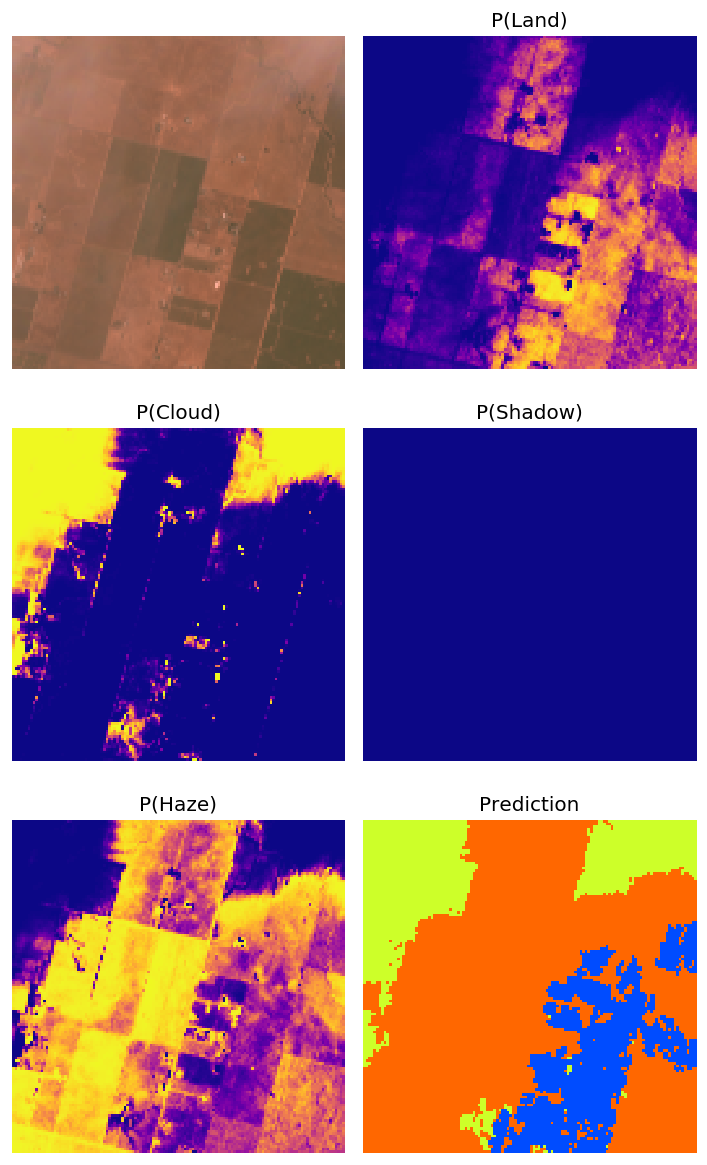

In [24]:
%matplotlib inline

fig, axes = plt.subplots(3, 2, dpi=120, figsize=(6, 10))

tplot = 7

# Time n, mean over bands
# rgb = np.squeeze(test[tplot].copy())
# rgb = rescale_intensity(rgb, out_range=(np.percentile(rgb, 5), np.percentile(rgb, 95)))

rgb = sat_bands[tplot][:3].copy()
for i in range(0, 3):
    rgb[i] = rescale_intensity(rgb[i], out_range=(np.percentile(rgb[i], 5), np.percentile(rgb[i], 95)))
rgb = rgb.transpose(1, 2, 0)
rgb = rgb[..., ::-1]

rgb /= rgb.max()

axes[0][0].imshow(rgb)
axes[0][0].axis('off')

# Time n, predicted probabilities for class k
axes[0][1].imshow(pred_c[tplot][class_labels.index('l')], vmin=0, vmax=1, cmap='plasma')
axes[0][1].set_title('P(Land)')
axes[0][1].axis('off')

axes[1][0].imshow(pred_c[tplot][class_labels.index('c')], vmin=0, vmax=1, cmap='plasma')
axes[1][0].set_title('P(Cloud)')
axes[1][0].axis('off')

axes[1][1].imshow(pred_c[tplot][class_labels.index('s')], vmin=0, vmax=1, cmap='plasma')
axes[1][1].set_title('P(Shadow)')
axes[1][1].axis('off')

axes[2][0].imshow(pred_c[tplot][class_labels.index('h')], vmin=0, vmax=1, cmap='plasma')
axes[2][0].set_title('P(Haze)')
axes[2][0].axis('off')

# pred_int = np.where(pred[tplot][classes.index('c')] >= pthresh, 1, 
#                     np.where(pred[tplot][classes.index('s')] >= pthresh, 2, 0))

pred_int = pred_c[tplot].argmax(axis=0) + 1

# pred_int = np.where((amax == classes.index('c')) & (pred[tplot][classes.index('c')] > pthresh), 1, 
#                     np.where((amax == classes.index('s')) & (pred[tplot][classes.index('s')] > pthresh), 2, 0))

kernel_cross = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], dtype='uint8')
kernel_square = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]], dtype='uint8')

pred_int = pymorph.closerec(pymorph.closerec(pred_int,
                                             Bdil=pymorph.secross(r=3),
                                             Bc=pymorph.secross(r=1)),
                            Bdil=pymorph.secross(r=2),
                            Bc=pymorph.secross(r=1))

# pred_int = cv2.erode(np.uint8(pred_int), kernel_square, iterations=1)
# pred_int = cv2.dilate(np.uint8(pred_int), kernel_square, iterations=3)

axes[2][1].imshow(pred_int, vmin=0, vmax=5, cmap='jet')
axes[2][1].set_title('Prediction')
axes[2][1].axis('off')

plt.tight_layout()

plt.show()

### Save the predictions to file

In [ ]:
cloud_file = '/scratch/rsc4/graesser/temp/clouds_{}_x{:.3f}_y{:.3f}.tif'.format(Path(filenames[tplot]).name.replace('.img', ''), x, y)

print(cloud_file)

if Path(cloud_file).is_file():
    os.remove(cloud_file)

with rio.open(cloud_file, mode='w', **pred_kwargs) as dst:
    dst.write(np.uint8(pred_int), indexes=1)

## Download PlanetScope data

In [ ]:
# download_data('/scratch/rsc4/graesser/temp/planet',
#               '/export/home/graesserj/code/python/github/planet/tsplanet/geojson/qld.geojson',
#               '2019-08-01', 
#               '2019-08-10',
#               cloud_cover=0.8,
#               api_key='des')

## Extract samples from training AOIs

In [ ]:
def setup_names(grid, filenames):
    
    rpath_dict = {'t55jel': '/scratch/rsc8/hardtkel/biocondition/biocondition/layers/sentinel/{}'.format(grid),
                  't56jkt': '/scratch/rsc8/hardtkel/biocondition/biocondition/layers/sentinel/{}'.format(grid),
                  't55kcu': '/scratch/rsc8/hardtkel/rapidfires/LW/{}'.format(grid),
                  'l8': '/media/jcgr/data/imagery/google/p225r083/brdf'}
    
    NameInfo = namedtuple('NameInfo', 'rasters vector, time_names')
    
    #vector_dir = Path('/scratch/rsc4/graesser/temp/s2/training')
    vector_dir = Path('/media/jcgr/data/imagery/google/training')
    
    image_dir = Path(rpath_dict[grid])
    
    filename_dict = dict()
    for fn in filenames:
        filename_dict[fn.split('_')[2]] = fn

    sorted_names = list(zip(*sorted(filename_dict.items())))
    
    filenames = list(sorted_names[1])
    
    time_names = [datetime.strptime(t, '%Y%m%d') for t in list(sorted_names[0])]
    
    rasters = [image_dir.joinpath(fn).as_posix() for fn in filenames]
    vector = vector_dir.joinpath('{}.shp'.format(grid)).as_posix()
    
    return NameInfo(rasters=rasters, vector=vector, time_names=time_names)

In [ ]:
filenames = fnmatch.filter(os.listdir(image_dir.as_posix()), '*.tif')

filename_dict = dict()
for fn in filenames:
    filename_dict[fn.split('_')[3]] = fn

In [ ]:
sorted_names = list(zip(*sorted(filename_dict.items())))

In [ ]:
filenames = list(sorted_names[1])

In [ ]:
time_names = [datetime.strptime(t, '%Y%m%d') for t in list(sorted_names[0])]

In [ ]:
rasters = [image_dir.joinpath(fn).as_posix() for fn in filenames]
vector = vector_dir.joinpath('p225r83.shp').as_posix()

### Plot the intersection

In [ ]:
# with gw.config.update(ref_image=rasters[0], 
#                       ref_res=(10, 10), 
#                       sensor='planetscope'):
    
#     with gw.open(rasters,
#                  time_names=time_names,
#                  how='intersection',
#                  chunks=512) as ds:
        
#         dss = ds.mean(dim='time')
#         dss.attrs = ds.attrs
#         print(ds)
        
#         #dss.gw.imshow(band_names=['red', 'green', 'blue'], nodata=0, robust=True)

### Extract samples

#### Split samples

In [ ]:
df = gpd.read_file(vector)

df['class_len'] = df['class'].str.len()
df['int_class'] = df.apply(str_to_int, axis=1)
out = df['int_class'].str.split(',', expand=True)

df_list = list()

for s in range(0, out.shape[1]):
    df_ = df.copy()
    df_['id'] = out.iloc[:, s]
    df_list.append(df_)

In [ ]:
df_list[1]

In [ ]:
dfs = list()

with gw.config.update(sensor='bgrn'):

    with gw.open(rasters[0]) as ds:
        transform = ds.transform

    with gw.open(rasters, time_names=time_names) as ds:    

        for ti, time in enumerate(ds.time.values):

            dss = ds.sel(time=time)
            dss.attrs = ds.attrs
            dss.attrs['transform'] = transform

            dfs.append(dss.gw.extract(df_list[ti]))

In [ ]:
dfs[0].shape

## Convert samples to CRF features

In [ ]:
band_names = ['blue', 'green', 'red', 'nir']
label_name = 'poly'

In [ ]:
results = samples_to_features(dfs)

### CRF X and y

In [ ]:
X = np.array(list(zip(*results))[0]).T.tolist()
print(len(X))

In [ ]:
y = np.array(list(zip(*results))[1]).T.tolist()
print(len(y))

### Fit the CRF model

In [ ]:
model = sklearn_crfsuite.CRF(algorithm='lbfgs', # Gradient descent using the limited-memory BFGS method (with L1 and L2 regularization)
            c1=0.01,
            c2=0.01,
            max_iterations=2000,
            num_memories=10,
            period=10,
            epsilon=1e-04,
            delta=1e-04,
            linesearch='StrongBacktracking',  # 'MoreThuente' 'Backtracking' 'StrongBacktracking'
            max_linesearch=20,
            all_possible_states=True,
            all_possible_transitions=True,
            verbose=False)

In [ ]:
model.fit(X, y)

In [ ]:
# model.predict_marginals(X)[0]

In [ ]:
# samples x time x n classes
# pred = np.array([[[ps['land'], ps['cloud']] for ps in p] for p in model.predict_marginals(X)], dtype='float64')

In [ ]:
# pred.shape

### Open the data to predict on 

In [ ]:
with gw.config.update(sensor='rgbn'):
    
    with gw.open(rasters[0]) as ds:
        #print(ds.data.max().compute())
        transform = ds.transform
    
    with gw.open(rasters, time_names=time_names) as ds:
        
        ds.attrs['transform'] = transform
        
        dss = ds[:, :, 3000:3512, 3000:3512].chunk((1, 256, 256)).fillna(0)
        #dss = gw.subset(ds, left=315416.003, top=-3611632.029, rows=500, cols=500).chunk((1, 1, 64, 64))
        #print(dss)
        #print(dss.data.max().compute())
        test = dss.astype('float64').data.compute()

In [ ]:
test.shape

In [ ]:
ntime, nbands, nrows, ncols = test.shape

### Convert the array to CRF-compatible features

In [ ]:
features = [tlayer.transpose(1, 2, 0).reshape(nrows*ncols, nbands) for tlayer in test]
features = [array_to_dict(*[features[j][i] for j in range(0, ntime)]) for i in range(0, nrows*ncols)]

In [ ]:
# features[0]

### Predict on all time steps

In [ ]:
pred = model.predict_marginals(features)

In [ ]:
def pred_to_labels(model_pred):
    
    # samples x time x n classes
    return np.array([[[ps['n'], ps['l'], ps['w'], ps['c'], ps['s'], ps['h']] for ps in p] for p in model_pred], dtype='float64')

In [ ]:
# samples x time x n classes
# pred = np.array([[[ps['n'], ps['l'], ps['w'], ps['c'], ps['s'], ps['h']] for ps in p] 
#                  for p in model.predict_marginals(features)], dtype='float64')

In [ ]:
pred = pred_to_labels(pred)

In [ ]:
pred.shape

In [ ]:
pred = pred.transpose(1, 2, 0).reshape(ntime, pred.shape[2], nrows, ncols)

In [ ]:
pred.shape

## Plot cloud probabilities

In [ ]:
%matplotlib inline

fig, axes = plt.subplots(pred.shape[0], 2, dpi=400, figsize=(2, 12))

bidx = 0 # band index
cidx = 3 # class index

for pi in range(0, pred.shape[0]):

    ip = test[pi, bidx, :, :]
    ip[ip == 0] = np.nan
    
    axes[pi][0].imshow(ip, vmin=np.nanpercentile(ip, 10), vmax=np.nanpercentile(ip, 90), cmap='plasma')
    #axes[pi][1].imshow(pred[pi, cidx, :, :], vmin=0, vmax=1, cmap='plasma')
    axes[pi][1].imshow(pred[pi, :, :, :].argmax(axis=0), vmin=0, vmax=5)
    
#     axes[pi][0].set_xlabel('Time {:d}'.format(pi+1))
    
    axes[pi][0].axis('off')
    axes[pi][1].axis('off')

plt.show()

### Shape testing

In [ ]:
# a = np.arange(8*3*2).reshape(8,3,2)

In [ ]:
# time 1
# a[:, 0, :]

In [ ]:
# time 2
# a[:, 1, :]

In [ ]:
# a.transpose(1, 2, 0).reshape(3, 2, 2, 4)[1]